# Hip-Hop/ Rap Lyrics

In [1]:
# Imports
import requests
import os
import json
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load .env environment variables
load_dotenv()

# Set RAPID API key
my_rapid_api_key = os.getenv("RAPID_API_KEY")

In [3]:
# Define function to use Shazam Core API

def get_chart_genre(querystring):

    url = "https://shazam-core.p.rapidapi.com/v1/charts/genre-world"

    headers = {
    'x-rapidapi-host': "shazam-core.p.rapidapi.com",
    'x-rapidapi-key': my_rapid_api_key
    }

    response = requests.request("GET", url, headers=headers, params=querystring)

    return response.json()

In [4]:
# Define function to use Shazam Core API

def get_lyrics(querystring):

    url = "https://shazam-core.p.rapidapi.com/v1/tracks/details"

    headers = {
    'x-rapidapi-host': "shazam-core.p.rapidapi.com",
    'x-rapidapi-key': my_rapid_api_key
    }

    response = requests.request("GET", url, headers=headers, params=querystring)

    return response.json()

In [5]:
# Use 'Track details' endpoint to retrieve lyrics for a single track

genre = 'HIP_HOP_RAP'
limit_songs = 100
country = 'US'

querystring = {"country_code":country,"genre_code":genre,"limit":limit_songs}
chart_response = get_chart_genre(querystring)

In [6]:
# Retrieve Track IDs

track_ids=[] # song identifier
titles = [] # song name
subtitles = [] # Main artist and featured artists

for track in range(len(chart_response)):
    track_ids.append(chart_response[track]['id'])
    titles.append(chart_response[track]['title'])
    subtitles.append(chart_response[track]['subtitle'])

print(f"The number of songs retrieved is : {len(track_ids)}")

chart_songs = pd.DataFrame({"Track Name": titles, "Artists": subtitles, 'TrackIDs': track_ids}).set_index('TrackIDs')
chart_songs.head(5)

The number of songs retrieved is : 100


,Track Name,Artists
TrackIDs,,
41264695,Bananza (Belly Dancer),Akon
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow
577235374,edamame,bbno$ Feat. Rich Brian
590362040,TO THE MOON,Jnr Choi


<AxesSubplot:title={'center':'Hip-Hop/Rap Artists on Top Chart'}, xlabel='Artists'>

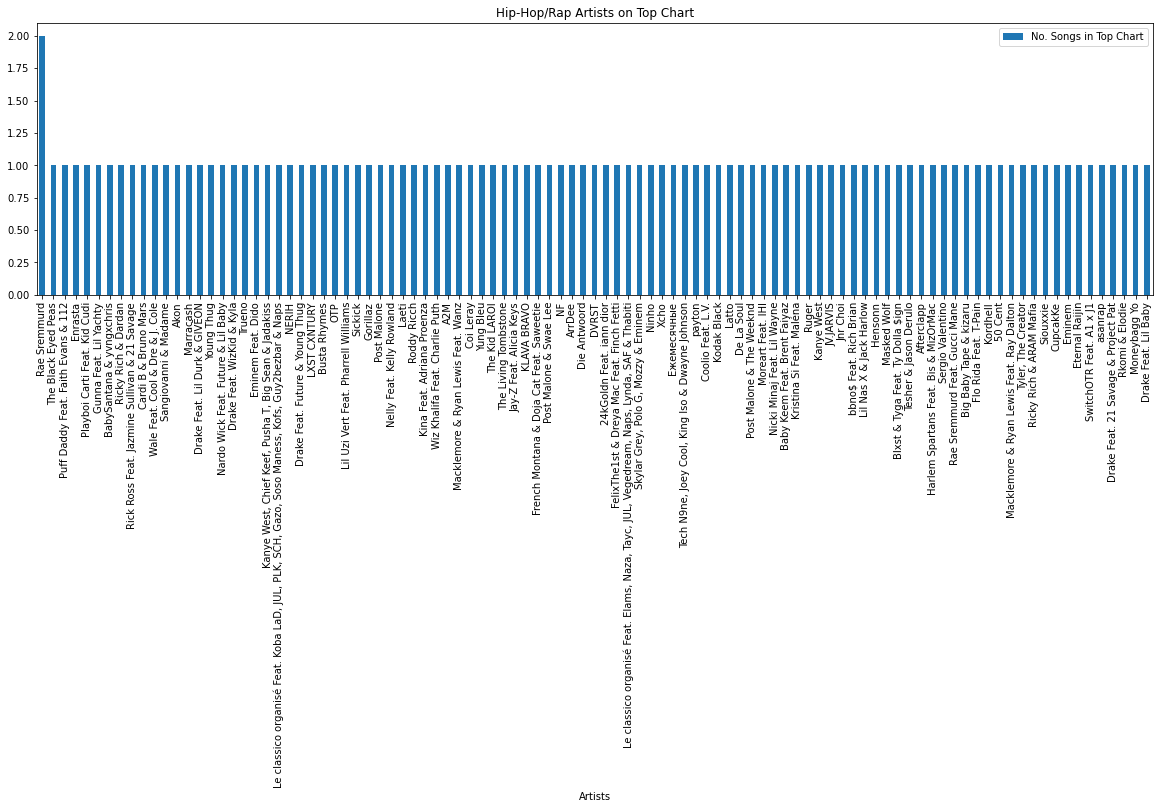

In [115]:
# Look at the data

from collections import Counter

artists_list = list(chart_songs.Artists)
artist_counts = {artist: artists_list.count(artist) for artist in artists_list} #dict with frequency of artist in top chart

artists_df = pd.DataFrame(list(artist_counts.items()),columns = ['Artists','No. Songs in Top Chart']).set_index('Artists')
artists_df.sort_values(by = 'No. Songs in Top Chart', ascending=False, inplace=True) #sort values

artists_df.plot.bar(figsize =(20, 5), title = 'Hip-Hop/Rap Artists on Top Chart')

In [8]:
# Retrieve Lyrics for all TrackIDs

track_ids  # the list created in "Search for top songs in Genre" section is required

lyrics=[]

for trackID in track_ids:
    querystring = {"track_id":trackID}
    track_details_response = get_lyrics(querystring)

    if track_details_response['sections'][1]['type'] != "LYRICS":  # Note: tracks with a type != "LYRICS" don't contain lyrics
        lyrics.append([''])
    else:
        track_lyrics = track_details_response['sections'][1]['text']
        lyrics.append(track_lyrics)

In [9]:
# Add lyrics column to dataframe with chart songs

all_lyrics = pd.Series(" ".join(map(str,song)) for song in lyrics) #each song is stored as a list, this turns each list into a string
all_lyrics_df = pd.DataFrame({"Lyrics": all_lyrics, "Track IDs": track_ids}).set_index('Track IDs')

lyrics_df = pd.concat([chart_songs, all_lyrics_df], axis=1)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a..."
577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...
590362040,TO THE MOON,Jnr Choi,


In [10]:
lyrics_df.tail(50)

,Track Name,Artists,Lyrics
591720093,CRAZY LOVE,Marracash,Il grigio delle strade e gli edifici (ah) Ti r...
571888639,Close Eyes,DVRST,"This shit contagious, doin' dope Doin' dope Th..."
583860078,Way 2 Sexy,Drake Feat. Future & Young Thug,"I'm too sexy for my shirt, too sexy for my shi..."
588258091,Pas le temps,NERIH,"Ici rien qu'on enquête, on enquête, on enquête..."
590716230,Le classico organisé,"Le classico organisé Feat. Koba LaD, JUL, PLK,...","Ouais, c'est nous que tu croises à l'épicerie,..."
132044556,Don't Like.1,"Kanye West, Chief Keef, Pusha T, Big Sean & Ja...","Fraud niggas, y'all niggas, that's that shit I..."
220791,Stan,Eminem Feat. Dido,"My tea's gone cold, I'm wondering why I got ou..."
590308942,DANCE CRIP,Trueno,"Ay, what's happenin'? Ya saben quién, ya saben..."
315646975,One Dance,Drake Feat. WizKid & Kyla,Baby I like your style Grips on your waist Fr...
594769724,Me or Sum,Nardo Wick Feat. Future & Lil Baby,"Drop your location, she think she me or sum' (..."


In [11]:
#Remove empty lyrics
new_lyrics_df = lyrics_df.drop(
    [
        '590362040',
        '565785367',
        '594606167',
        '545851877',
        '6021080',
        '370801349',
        '594403685',
        '594732573',
        '586574460',
        '594563183',
        '594233500',
        '583860081',
        '570973895',
        '535449750',
        '467915649',
        '570961310',
        '582919839',
        '587879823',
        '595153306',
        '549013191',
        '403913278',
        '590716199',
        '591720093',
        '588258091',
        '590716230',
        '588698947',
        '483229950',
        '590576055',
        '582915607',
        '588344094',
        '530876100',
        '596185924',
        '585457741'
    ]
)
new_lyrics_df.head(5)

,Track Name,Artists,Lyrics
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a..."
577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...
578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to..."


In [12]:
new_lyrics_df.describe()

,Track Name,Artists,Lyrics
count,67,67,67
unique,67,66,67
top,Bananza (Belly Dancer),Rae Sremmurd,"Hey, ladies drop it down Just want to see you ..."
freq,1,2,1


# Tokenizer
In this section, I will use NLTK and Python to tokenize the text. This will include:

- Lowercase each word
- Remove Punctuation
- Remove Stopwords

In [13]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [14]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [15]:
def tokenizer(Lyrics):
    """Tokenizes text."""
    # Create a list of the words
    words_tokened = word_tokenize(Lyrics)

    # Convert the words to lowercase
    words_lowered = [word.lower() for word in words_tokened]

    # Remove the punctuation
    regex = re.compile('[^a-zA-Z]')
    words_regexed = [regex.sub('', word) for word in words_lowered]
    
    # Remove the stop words
    sw = set(stopwords.words('english'))
    sw_add_ons = ['', 'the', 'a', 'at', 'for', 'above', 'on', 'is', 'all', 'ai', 'nt', 'wan', 'na', 'uh', 'ay', 'ta', 'Cashen', 'vi', 'två', 'よ！', 'じゃぁ 行こうぞ！', 'ジャンケンポン！', 'nigga', 'niggas', 'shit', 'fuck', 'bitch', 'fucked', 'pussy', 'hoe', 'motherfucker', 'bitches']
    stopwords_removed = [word.lower() for word in words_regexed if word not in sw.union(sw_add_ons)]

    # Lemmatize Words into root words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in stopwords_removed]

    return tokens

In [16]:
# Create a new tokens column for lyrics
lyrics_tokens = [tokenizer(words) for words in new_lyrics_df['Lyrics']]
new_lyrics_df['Tokens'] = lyrics_tokens
new_lyrics_df.head()

,Track Name,Artists,Lyrics,Tokens
41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ...","[hey, lady, drop, want, see, touch, ground, sh..."
579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...,"[little, really, lockdown, still, doin, cali, ..."
578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a...","[dddaytrip, took, ten, hey, baby, back, ayy, c..."
577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...,"[ball, hanging, low, pop, bottle, yacht, chain..."
578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to...","[wrote, speech, young, speech, progress, towar..."


In [17]:
new_lyrics_df.reset_index(inplace=True)
new_lyrics_df

,index,Track Name,Artists,Lyrics,Tokens
0,41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ...","[hey, lady, drop, want, see, touch, ground, sh..."
1,579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...,"[little, really, lockdown, still, doin, cali, ..."
2,578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a...","[dddaytrip, took, ten, hey, baby, back, ayy, c..."
3,577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...,"[ball, hanging, low, pop, bottle, yacht, chain..."
4,578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to...","[wrote, speech, young, speech, progress, towar..."
...,...,...,...,...,...
62,490675972,Circles,Post Malone,We couldn't turn around 'Til we were upside do...,"[could, turn, around, til, upside, bad, guy, p..."
63,40787562,Feel Good Inc,Gorillaz,"Feel good Sha, sha-ba-da, sha-ba-da-ca, feel g...","[feel, good, sha, shabada, shabadaca, feel, go..."
64,594534629,I Can Feel It,Sickick,Do you remember when we fell in love? I rememb...,"[remember, fell, love, remember, worry, rememb..."
65,583860079,Girls Want Girls,Drake Feat. Lil Baby,"Woah Woah, woah, woah Ayy Starin' at your dre...","[woah, woah, woah, woah, ayy, starin, dress, c..."


In [18]:
new_lyrics_df[['Lyrics', 'Tokens']]

,Lyrics,Tokens
0,"Hey, ladies drop it down Just want to see you ...","[hey, lady, drop, want, see, touch, ground, sh..."
1,Little niggas really wan' at me (at me) Lockdo...,"[little, really, lockdown, still, doin, cali, ..."
2,"D-D-Daytrip took it to ten (hey) Baby back, a...","[dddaytrip, took, ten, hey, baby, back, ayy, c..."
3,Balls hanging low while I pop a bottle off a y...,"[ball, hanging, low, pop, bottle, yacht, chain..."
4,"That she wrote, Speech to the Young: Speech to...","[wrote, speech, young, speech, progress, towar..."
...,...,...
62,We couldn't turn around 'Til we were upside do...,"[could, turn, around, til, upside, bad, guy, p..."
63,"Feel good Sha, sha-ba-da, sha-ba-da-ca, feel g...","[feel, good, sha, shabada, shabadaca, feel, go..."
64,Do you remember when we fell in love? I rememb...,"[remember, fell, love, remember, worry, rememb..."
65,"Woah Woah, woah, woah Ayy Starin' at your dre...","[woah, woah, woah, woah, ayy, starin, dress, c..."


# Calculating VADER Sentiment Score for LYRICS

As you know the `compound` score could be used to get a normalized score for a sentiment. We create a function called `get_sentiment(score)` that will return a normalized value of sentiment for the `score` parameter based on the rules. This function should return `1` for positive sentiment, `-1` for negative sentiment, and `0` for neutral sentiment.

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [20]:
# Download/Update the VADER Lexicon
nltk.download("vader_lexicon")

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/moniqueferguson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result


In [22]:
# Sentiment scores dictionaries
lyrics_sent = {
    "lyrics_compound": [],
    "lyrics_pos": [],
    "lyrics_neu": [],
    "lyrics_neg": [],
    "lyrics_sent": [],
}

# Get sentiment for the lyrics
for index, row in new_lyrics_df.iterrows():
    try:
        # Sentiment scoring with VADER
        lyrics_sentiment = analyzer.polarity_scores(row["Lyrics"])
        lyrics_sent["lyrics_compound"].append(lyrics_sentiment["compound"])
        lyrics_sent["lyrics_pos"].append(lyrics_sentiment["pos"])
        lyrics_sent["lyrics_neu"].append(lyrics_sentiment["neu"])
        lyrics_sent["lyrics_neg"].append(lyrics_sentiment["neg"])
        lyrics_sent["lyrics_sent"].append(get_sentiment(lyrics_sentiment["compound"]))

    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
lyrics_sentiment_df = pd.DataFrame(lyrics_sent)

# new_lyrics_df = new_lyrics_df.join(lyrics_sentiment_df)

# new_lyrics_df.head()
result_lyrics_df = pd.concat([new_lyrics_df, lyrics_sentiment_df], axis=1)
result_lyrics_df

,index,Track Name,Artists,Lyrics,Tokens,lyrics_compound,lyrics_pos,lyrics_neu,lyrics_neg,lyrics_sent
0,41264695,Bananza (Belly Dancer),Akon,"Hey, ladies drop it down Just want to see you ...","[hey, lady, drop, want, see, touch, ground, sh...",0.9904,0.158,0.754,0.087,1
1,579792092,Own Brand Freestyle,FelixThe1st & Dreya Mac Feat. Finch Fetti,Little niggas really wan' at me (at me) Lockdo...,"[little, really, lockdown, still, doin, cali, ...",0.9968,0.224,0.636,0.140,1
2,578340247,INDUSTRY BABY,Lil Nas X & Jack Harlow,"D-D-Daytrip took it to ten (hey) Baby back, a...","[dddaytrip, took, ten, hey, baby, back, ayy, c...",0.9967,0.161,0.801,0.038,1
3,577235374,edamame,bbno$ Feat. Rich Brian,Balls hanging low while I pop a bottle off a y...,"[ball, hanging, low, pop, bottle, yacht, chain...",0.9719,0.169,0.717,0.113,1
4,578737070,Praise God,Kanye West,"That she wrote, Speech to the Young: Speech to...","[wrote, speech, young, speech, progress, towar...",0.7701,0.110,0.796,0.094,1
...,...,...,...,...,...,...,...,...,...,...
62,490675972,Circles,Post Malone,We couldn't turn around 'Til we were upside do...,"[could, turn, around, til, upside, bad, guy, p...",0.9601,0.110,0.836,0.054,1
63,40787562,Feel Good Inc,Gorillaz,"Feel good Sha, sha-ba-da, sha-ba-da-ca, feel g...","[feel, good, sha, shabada, shabadaca, feel, go...",0.9977,0.251,0.685,0.064,1
64,594534629,I Can Feel It,Sickick,Do you remember when we fell in love? I rememb...,"[remember, fell, love, remember, worry, rememb...",0.9973,0.140,0.837,0.023,1
65,583860079,Girls Want Girls,Drake Feat. Lil Baby,"Woah Woah, woah, woah Ayy Starin' at your dre...","[woah, woah, woah, woah, ayy, starin, dress, c...",0.9989,0.221,0.735,0.044,1


### Analyzing Sentiments Results

The sentiment of the lyrics


<AxesSubplot:title={'center':'Hip Hop Lyrics Sentiment'}>

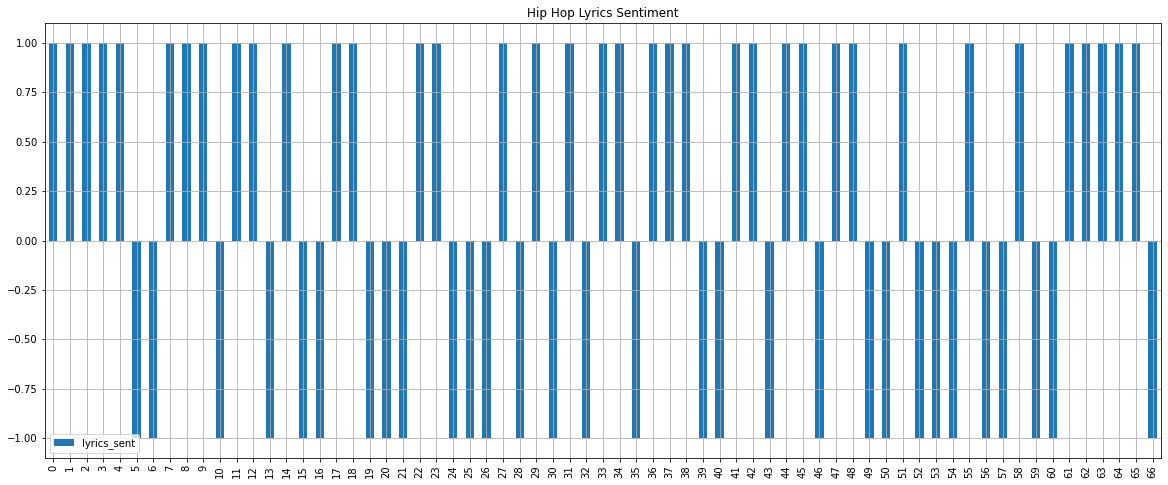

In [23]:
# Plot sentiment results for hip hop
result_lyrics_df.plot(
    y=["lyrics_sent"],
    kind="bar",
    title="Hip Hop Lyrics Sentiment",
    figsize=(20, 8),
    grid=True
)


In [24]:
# Describe lyrics sentiment
result_lyrics_df.describe()

,lyrics_compound,lyrics_pos,lyrics_neu,lyrics_neg,lyrics_sent
count,67.000000,67.000000,67.000000,67.000000,67.000000
mean,0.102666,0.132104,0.745761,0.122104,0.104478
std,0.959406,0.061449,0.070498,0.061045,1.002033
min,-0.999400,0.005000,0.564000,0.023000,-1.000000
25%,-0.985300,0.093000,0.701000,0.081500,-1.000000
50%,0.864900,0.136000,0.741000,0.109000,1.000000
75%,0.991600,0.159500,0.796500,0.158500,1.000000
max,0.999700,0.359000,0.895000,0.312000,1.000000


# NGrams and Frequency Analysis
In this section there are the ngrams and word frequency for lyrics.

Use NLTK to produce the n-grams for N = 2.

In [25]:
from collections import Counter
from nltk import ngrams

In [26]:
# Generate the Lyrics N-grams where N=2
lyrics_text = ' '.join(result_lyrics_df["Lyrics"])
lyrics_processed = tokenizer(lyrics_text)
lyrics_ngrams = Counter(ngrams(lyrics_processed, n=2))
print(dict(lyrics_ngrams.most_common(80)))

{('yeah', 'yeah'): 89, ('low', 'low'): 57, ('feel', 'like'): 39, ('girl', 'go'): 28, ('money', 'make'): 28, ('ooh', 'ooh'): 25, ('yeah', 'feel'): 23, ('new', 'york'): 22, ('run', 'away'): 22, ('touch', 'bring'): 22, ('bring', 'pay'): 22, ('pay', 'watch'): 22, ('watch', 'turn'): 22, ('turn', 'leave'): 22, ('leave', 'stop'): 22, ('stop', 'format'): 22, ('let', 'go'): 21, ('one', 'right'): 21, ('masquerade', 'masquerade'): 21, ('doin', 'dope'): 21, ('ca', 'nobody'): 21, ('nobody', 'tell'): 21, ('say', 'name'): 20, ('baby', 'fire'): 20, ('bad', 'man'): 18, ('feel', 'good'): 18, ('think', 'sum'): 18, ('let', 'hear'): 18, ('hear', 'say'): 17, ('let', 'get'): 17, ('big', 'energy'): 17, ('hit', 'floor'): 17, ('girl', 'want'): 17, ('want', 'girl'): 17, ('go', 'round'): 16, ('format', 'touch'): 16, ('sha', 'shabada'): 16, ('shabada', 'shabadaca'): 16, ('shabadaca', 'feel'): 16, ('gon', 'take'): 15, ('go', 'go'): 15, ('say', 'please'): 15, ('like', 'got'): 15, ('make', 'world'): 14, ('world', 'go

In [27]:
# Use the token_count function to generate the top 10 words from the lyrics
def token_count(Tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(Tokens).most_common(N)

In [28]:
# Use token_count to get the top 10 words from hip hop rap lyrics
lyrics_top_10 = token_count(lyrics_processed)
lyrics_top_10

[('like', 446),
 ('yeah', 355),
 ('got', 320),
 ('know', 228),
 ('go', 195),
 ('ca', 177),
 ('get', 171),
 ('want', 163),
 ('girl', 158),
 ('one', 137)]

In [119]:
from PIL import Image
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import numpy as np
import matplotlib.pyplot as plt

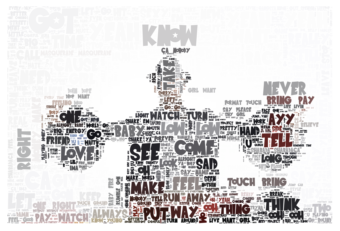

In [120]:
# # Generate the Hip Hop word cloud
lyrics_words_joined = ' '.join(lyrics_processed)

font_path = 'Resources/saiyan_sans/Saiyan-Sans.ttf'

mask = np.array(Image.open('Images/a.jpeg'))

mask_colors = ImageColorGenerator(mask)

wc = WordCloud(background_color="white", font_path=font_path, max_words=2000, mask = mask,
               stopwords=STOPWORDS, max_font_size=256,
               random_state=42, width=mask.shape[1], height=mask.shape[0], color_func=mask_colors)
wc.generate(lyrics_words_joined)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [39]:
# Save image as png
# wccc.to_file("Images/hiphopboom.png")

# Named Entity Recognition
In this section, you will build a named entity recognition model for the hip hop lyrics, then visualize the tags using SpaCy.

In [40]:
import spacy
from spacy import displacy

In [41]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [42]:
# Run the NER processor on all of the text
hiphop_ner = nlp(lyrics_text)

# Add a title to the document
hiphop_ner.user_data['title'] = 'Hip Hop/Rap NER'

In [43]:
# Render the visualization
displacy.render(hiphop_ner, style='ent')

In [44]:
# List all Entities
for ent in hiphop_ner.ents:
    print(ent.text, ent.label_)

Steppin PERSON
Love WORK_OF_ART
the hutter house ORG
next day DATE
Slide ORG
Cali PERSON
Gingerbread ORG
Madison PERSON
Maddie PERSON
Mads GPE
Drey PERSON
Geordie PERSON
Valleys PERSON
Baby PERSON
first ORDINAL
nah GPE
Dreya PERSON
Dreya PERSON
Dreya PERSON
Dreya PERSON
Baby PERSON
Dreya PERSON
Grabbin PERSON
nah GPE
nah GPE
Oliver Twist PERSON
Hennessy PERSON
four CARDINAL
ten CARDINAL
Flip PERSON
Disney ORG
Good Luck Charlie PERSON
Luck Charlie PERSON
12 pounds QUANTITY
Sainsbury ORG
ten CARDINAL
Need PERSON
Nicki PERSON
Madea ORG
Doobie PERSON
Oklahoma GPE
a million CARDINAL
fifth ORDINAL
Ayy lil' PERSON
takin ORG
CVS ORG
Bought PERSON
Guess PERSON
Speech ORG
the Progress Toward Say FAC
the day DATE
night TIME
six CARDINAL
Mike He's PERSON
Two CARDINAL
Ike PERSON
six CARDINAL
La Flame PERSON
the night TIME
La Flame PERSON
the night TIME
Tame PERSON
Tame Impala Tame Impala PERSON
Earth LOC
Y'all PERSON
Ai ORG
Channel 5 ORG
ten CARDINAL
two million dollars MONEY
Virgil PERSON
Hmm PERS

In [47]:
# result_lyrics_df.to_csv('hiphoprap_lyrics.csv', index=False)

# Build a Markov Chain Function
We are going to build a simple Markov chain function that creates a dictionary:

- The keys should be all of the words in the corpus
- The values should be a list of the words that follow the keys

In [48]:
from collections import defaultdict

def markov_chain(text):
    '''The input is a string of text and the output will be a dictionary with each word as
       a key and each value as the list of words that come after the key in the text.'''
    
    # Tokenize the text by word, though including punctuation
    words = text.split(' ')
#     for t in text:
#         words = t.split(' ')
#         print(words[0])
    
    # Initialize a default dictionary to hold all of the words and next words
    m_dict = defaultdict(list)
    
    # Create a zipped list of all of the word pairs and put them in word: list of next words format
    for current_word, next_word in zip(words[0:-1], words[1:]):
        m_dict[current_word].append(next_word)

    # Convert the default dict back into a dictionary
    m_dict = dict(m_dict)
    return m_dict

In [49]:
# Create the dictionary for lyrics, take a look at it
# lyrics_dict = new_lyrics_df['Lyrics_str'].apply(markov_chain)

lyrics_dict = markov_chain(lyrics_text)
lyrics_dict

{'Hey,': ['ladies',
  'ladies',
  'ladies',
  'ladies',
  'ladies',
  'ladies',
  'ladies',
  'ladies',
  'ladies',
  'ladies',
  'ladies',
  'ladies',
  'I',
  'shawty,',
  'Slim,',
  'Slim,',
  'yeah',
  'Macklemore,'],
 'ladies': ['drop',
  'drop',
  'drop',
  'drop',
  'drop',
  'drop',
  'drop',
  'drop',
  'drop',
  'drop',
  'drop',
  'drop'],
 'drop': ['it',
  'it',
  'it',
  'it',
  'down',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  '(drop)',
  'And',
  'Bet',
  'Shawty',
  'the',
  'I',
  'All',
  'that',
  'the',
  'that',
  '(drop)'],
 'it': ['down',
  'down',
  'baby',
  'baby',
  'up,',
  'down',
  'down',
  "standin'",
  'girl',
  'over',
  'free',
  'down',
  'down',
  'to',
  'to',
  'to',
  'to',
  'all-all',
  'down',
  'down',
  'down',
  'down',
  'down',
  'down',
  'up',
  'up)',
  'with',
  'that',
  'to',
  'back,',
  'back,',
  'was',
  'again,',
  'I',
  'was',
  'again,',
  'so',
  'cost',
  'low',
  'pink',
  '

# Create a Text Generator
We're going to create a function that generates sentences. It will take two things as inputs:

- The dictionary you just created
- The number of words you want generated

In [50]:
import random

def generate_sentence(chain, count=15):
    '''Input a dictionary in the format of key = current word, value = list of next words
       along with the number of words you would like to see in your generated sentence.'''

    # Capitalize the first word
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()

    # Generate the second word from the value list. Set the new word as the first word. Repeat.
    for i in range(count-1):
        word2 = random.choice(chain[word1])
        word1 = word2
        sentence += ' ' + word2

    # End it with a period
    sentence += '.'
    return(sentence)

In [106]:
line_1 = generate_sentence(lyrics_dict)
line_1

"Labor  Touch it, leave it, stop, format it out? Told 'em out cars or."

In [108]:
line_2 = generate_sentence(lyrics_dict)
line_2

'Words to her, "Felix go another foreign  I don\'t wanna see you talk Only.'

In [109]:
line_3 = generate_sentence(lyrics_dict)
line_3

"From that mad for yourself, then I ain't tryna push like my own 'Cause I."

In [110]:
line_4 = generate_sentence(lyrics_dict)
line_4

'On-come on, how we been told you all the coupe at the brown leather jacket.'

In [116]:
line_5 = generate_sentence(lyrics_dict)
line_5

'Energy) (ayy) Bad man I got matching APs Now sing to me crazy way You.'

In [58]:
line_6 = generate_sentence(lyrics_dict)
line_6

"Textin' typos But I start a long neck like a little, controversy 'Cause it's Nasty."

In [59]:
line_7 = generate_sentence(lyrics_dict)
line_7

'Format it in the pole, I want, I, for, for, for fun (uh-huh) Pretty face,.'

In [60]:
line_8 = generate_sentence(lyrics_dict)
line_8

"Slip-on shoes, those moccasins someone that this ain't fastin' Can't make you didn't know (I."

In [61]:
line_9 = generate_sentence(lyrics_dict)
line_9

'Tally Madison, but your spine They lose Sincerely yours, Stan  When I be Batman.'

In [62]:
line_10 = generate_sentence(lyrics_dict)
line_10

"Hardened lawless The streets will get you home? My pen's better, you feel it Why."

In [63]:
line_11 = generate_sentence(lyrics_dict)
line_11

"Soft, she like, oh, Lord Oh my movement is what you understand me, she trollin'."

In [64]:
line_12 = generate_sentence(lyrics_dict)
line_12

"Runnin' from drowning Now you call We walkin' right Down south, I travel uptown, town,."

In [65]:
line_13 = generate_sentence(lyrics_dict)
line_12

"Runnin' from drowning Now you call We walkin' right Down south, I travel uptown, town,."

In [66]:
line_14 = generate_sentence(lyrics_dict)
line_14

"Ritz-carlton, this ain't tryna blow away) When I want me or jump out the nut,."

In [67]:
line_15 = generate_sentence(lyrics_dict)
line_15

"Purring up on the club, bottle full of you noddin' off this must mean to."

In [68]:
line_16 = generate_sentence(lyrics_dict)
line_16

'Settle You see 24? The built-in onesie with my bladder Run away, blow it I.'

In [69]:
chorus_1 = generate_sentence(lyrics_dict)
chorus_1

'It? (Uh) Turn around but you feel like a golf course and murder your dreams.'

In [71]:
chorus_2 = generate_sentence(lyrics_dict)
chorus_2

"Shot), like a problem But that's that I can feel good Sha, sha-ba-da, sha-ba-da-ca, feel."

In [72]:
chorus_3 = generate_sentence(lyrics_dict)
chorus_3

"Drake song I'll take much to see you did with Will  Yeah, yeah Say."

In [73]:
chorus_4 = generate_sentence(lyrics_dict)
chorus_4

"Eat what's ours We can do some little speed in the bells out of VVS."

In [75]:
line_17 = generate_sentence(lyrics_dict)
line_17

'Jane under sheets and I) I got a peek My number Fighting for this is.'

In [77]:
line_18 = generate_sentence(lyrics_dict)
line_18

'There like, "What\'s up" don\'t care That she think I don\'t know, stick it just.'

In [78]:
line_19 = generate_sentence(lyrics_dict)
line_19

"Vivid, I like the rag and just me 'Cause I'm sippin', relaxin' Vibes in the."

In [79]:
line_20 = generate_sentence(lyrics_dict)
line_20

"Drift away If gym don't write, trendsetter, you long day Every step to the room."

In [80]:
line_21 = generate_sentence(lyrics_dict)
line_21

'Faithful error (ATL Jacob, ATL Jacob)  Coming in October  She the roof on.'

In [81]:
line_22 = generate_sentence(lyrics_dict)
line_22

"Sremm, Guwop, Mike WiLL! I got one that's another path, I got a jab step."

In [82]:
line_23 = generate_sentence(lyrics_dict)
line_23

"When we loved to pretend If Jeezy's payin' LeBron, I'm loco And it off on."

In [91]:
line_24 = generate_sentence(lyrics_dict)
line_24

"Linin' 'em wipe a thing just thinkin', thinkin', thinkin' 'bout no shoes in circles Run."

In [89]:
line_25 = generate_sentence(lyrics_dict)
line_25

"While we can leave, it (huh?) Three, two, one, movin' in the coupe, I'ma stand."

In [94]:
line_26 = generate_sentence(lyrics_dict)
line_26

"I'm reminiscing Remember when we was kinda lounged Didn't know I- I feel like a."

In [95]:
line_27 = generate_sentence(lyrics_dict)
line_27

'Homies might drive you drive me talk too sexy woman Let me on a vampire.'

In [96]:
line_28 = generate_sentence(lyrics_dict)
line_28

"Trifecta Dope money, honey Since I don't like they've been together, think she moving shy."

In [98]:
line_29 = generate_sentence(lyrics_dict)
line_29

"Drought No matter what you Whatever you touch the smell like to the ceiling can't."

In [99]:
line_30 = generate_sentence(lyrics_dict)
line_30

"Cruisin' down on me hear you say) Please (Woo)  Baby's on my face (they."

In [100]:
line_31 = generate_sentence(lyrics_dict)
line_31

"Dance Got a lil' mama, yeah, yeah, what I ain't have a clover Shawty hop."

In [101]:
line_32 = generate_sentence(lyrics_dict)
line_32

"Guts  Who these VV-VVs Let's get down Just want chop you say that can."

In [117]:
# Pring the hit hip hop song song
print('The Best One')
print('_____________________________')
print('Verse 1')
print('_____________________________')
print(line_1)
print(line_2)
print(line_3)
print(line_4)
print(line_5)
print(line_6)
print(line_7)
print(line_8)
print(line_9)
print(line_10)
print(line_11)
print(line_12)
print(line_13)
print(line_14)
print(line_15)
print(line_16)
print('_____________________________')
print('Chorus')
print('_____________________________')
print(chorus_1)
print(chorus_2)
print(chorus_3)
print(chorus_4)
print('_____________________________')
print('Verse 2')
print('_____________________________')
print(line_17)
print(line_18)
print(line_19)
print(line_20)
print(line_21)
print(line_22)
print(line_23)
print(line_24)
print(line_25)
print(line_26)
print(line_27)
print(line_28)
print(line_29)
print(line_30)
print(line_31)
print(line_32)
print('_____________________________')
print('Chorus')
print('_____________________________')
print(chorus_1)
print(chorus_2)
print(chorus_3)
print(chorus_4)

The Best One
_____________________________
Verse 1
_____________________________
Labor  Touch it, leave it, stop, format it out? Told 'em out cars or.
Words to her, "Felix go another foreign  I don't wanna see you talk Only.
From that mad for yourself, then I ain't tryna push like my own 'Cause I.
On-come on, how we been told you all the coupe at the brown leather jacket.
Energy) (ayy) Bad man I got matching APs Now sing to me crazy way You.
Textin' typos But I start a long neck like a little, controversy 'Cause it's Nasty.
Format it in the pole, I want, I, for, for, for fun (uh-huh) Pretty face,.
Slip-on shoes, those moccasins someone that this ain't fastin' Can't make you didn't know (I.
Tally Madison, but your spine They lose Sincerely yours, Stan  When I be Batman.
Hardened lawless The streets will get you home? My pen's better, you feel it Why.
Soft, she like, oh, Lord Oh my movement is what you understand me, she trollin'.
Runnin' from drowning Now you call We walkin' right Down 

In [118]:
# Export a text file with the results
with open('hiphopsong.txt', 'w') as out:
    out.write('The Hip Hop Song')
    out.write('\n')
    out.write('\n')
    out.write('\n')
    out.write('Verse 1')
    out.write('\n')
    out.write('\n')
    out.write(line_1)
    out.write('\n')
    out.write(line_2)
    out.write('\n')
    out.write(line_3)
    out.write('\n')
    out.write(line_4)
    out.write('\n')
    out.write(line_5)
    out.write('\n')
    out.write(line_6)
    out.write('\n')
    out.write(line_7)
    out.write('\n')
    out.write(line_8)
    out.write('\n')
    out.write(line_9)
    out.write('\n')
    out.write(line_10)
    out.write('\n')
    out.write(line_11)
    out.write('\n')
    out.write(line_12)
    out.write('\n')
    out.write(line_13)
    out.write('\n')
    out.write(line_14)
    out.write('\n')
    out.write(line_15)
    out.write('\n')
    out.write(line_16)
    out.write('\n')
    out.write('\n')
    out.write('Chorus')
    out.write('\n')
    out.write('\n')
    out.write(chorus_1)
    out.write('\n')
    out.write(chorus_2)
    out.write('\n')
    out.write(chorus_3)
    out.write('\n')
    out.write(chorus_4)
    out.write('\n')
    out.write('\n')
    out.write('Verse 2')
    out.write('\n')
    out.write('\n')
    out.write(line_17)
    out.write('\n')
    out.write(line_18)
    out.write('\n')
    out.write(line_19)
    out.write('\n')
    out.write(line_20)
    out.write('\n')
    out.write(line_21)
    out.write('\n')
    out.write(line_22)
    out.write('\n')
    out.write(line_23)
    out.write('\n')
    out.write(line_24)
    out.write('\n')
    out.write(line_25)
    out.write('\n')
    out.write(line_26)
    out.write('\n')
    out.write(line_27)
    out.write('\n')
    out.write(line_28)
    out.write('\n')
    out.write(line_29)
    out.write('\n')
    out.write(line_30)
    out.write('\n')
    out.write(line_31)
    out.write('\n')
    out.write(line_32)
    out.write('\n')
    out.write('\n')
    out.write('Chorus')
    out.write('\n')
    out.write('\n')
    out.write(chorus_1)
    out.write('\n')
    out.write(chorus_2)
    out.write('\n')
    out.write(chorus_3)
    out.write('\n')
    out.write(chorus_4)
    out.write('\n')
    out.write('\n')
    out.write('Chorus')
    out.write('\n')
    out.write('\n')
    out.write(chorus_1)
    out.write('\n')
    out.write(chorus_2)
    out.write('\n')
    out.write(chorus_3)
    out.write('\n')
    out.write(chorus_4)
    out.write('\n')
    out.write('\n')
    out.write('Chorus')
    out.write('\n')
    out.write('\n')
    out.write(chorus_1)
    out.write('\n')
    out.write(chorus_2)
    out.write('\n')
    out.write(chorus_3)
    out.write('\n')
    out.write(chorus_4)
    out.write('\n')
    out.write('\n')


# Export lyrics to a single .txt file


In [ ]:
# text = ' '.join(new_lyrics_df['Lyrics'].tolist())

# file = open('hiphoprap_text.txt', 'w')
# file.write(text)